# Technical Indicators

Importing Libraries and Modules

In [1]:
import numpy as np

import pandas as pd
from pandas_datareader import data as web

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode()

import warnings
warnings.simplefilter("ignore")

from datetime import date, timedelta
import time

import yfinance as yf

import cufflinks as cf
cf.go_offline()

from scipy.signal import argrelextrema
from scipy.stats import linregress


Importing Stock Data

In [2]:
stock_name = input("Enter the stock name\n")
stock_data = yf.download(tickers = stock_name + '.NS' ,period = '10y', interval = '1d')
x_axis = stock_data.index

Enter the stock name
TATAELXSI
[*********************100%***********************]  1 of 1 completed


Plotting Technical Indicators

1.) Simple Moving Average (SMA)

Shorter Period for SMA

Longer Period for SMA

Period for average Volume



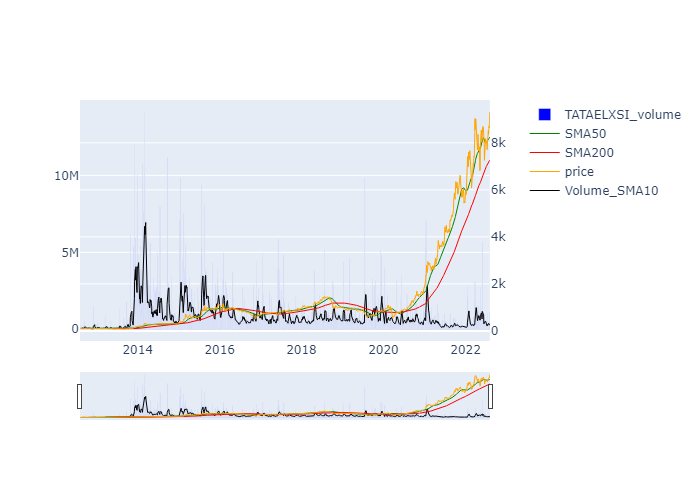

In [3]:
#SMA for price and volume

x = int(input("Shorter Period for SMA\n") or 50)
y = int(input("Longer Period for SMA\n") or 200)
z = int(input("Period for average Volume\n") or 10)

MAx_data = stock_data['Close'].rolling(x).mean()
MAy_data = stock_data['Close'].rolling(y).mean()
price_data = stock_data['Close']
Volume_MA_data = stock_data['Volume'].rolling(z).mean()

MAx = go.Scatter(x=x_axis, y=MAx_data, line=dict(color='green', width=1), name="SMA"+str(x))
MAy = go.Scatter(x=x_axis, y=MAy_data, line=dict(color='red', width=1), name="SMA"+str(y))
price = go.Scatter(x=x_axis, y=price_data, line=dict(color='orange', width=1), name="price")
stock_volume = go.Bar(x=x_axis, y=stock_data['Volume'], marker_color='blue',name=stock_name + '_volume' )
MA_volume = go.Scatter(x=x_axis, y=Volume_MA_data, line=dict(color='black', width=1), name="Volume_SMA"+str(z))

stock_data["SMA"+str(x)] = MAx_data
stock_data["SMA"+str(y)] = MAy_data
stock_data["Volume_SMA"+str(z)] = Volume_MA_data

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.add_trace(trace=stock_volume, secondary_y = False)
fig.add_trace(trace=MAx, secondary_y = True)
fig.add_trace(trace=MAy, secondary_y = True)
fig.add_trace(trace=price, secondary_y = True)
fig.add_trace(trace = MA_volume, secondary_y=False)
fig.update_xaxes(rangeslider_visible=True)
fig.show("png")

2.) Exponential Moving Average (EMA)

Shorter Period for EMA

Longer Period for EMA



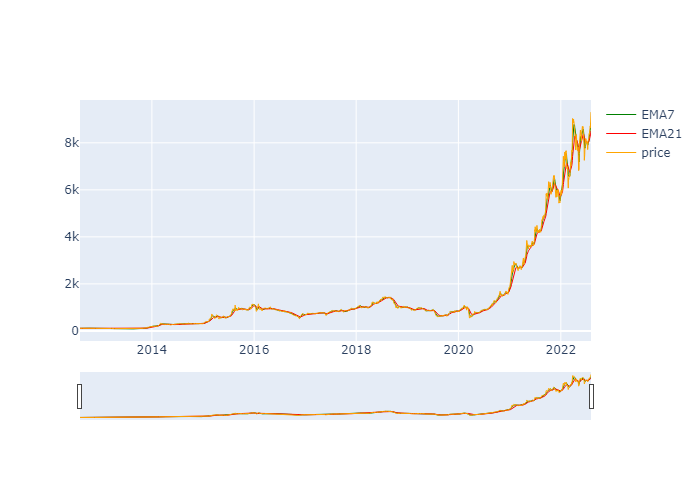

In [4]:
#EMA 

x = int(input("Shorter Period for EMA\n") or 7)
y = int(input("Longer Period for EMA\n") or 21)

EMAx_data = stock_data['Close'].ewm(span=x, adjust=False).mean()
EMAy_data = stock_data['Close'].ewm(span=y, adjust=False).mean()
price_data = stock_data['Close']

stock_data["EMA"+str(x)] = EMAx_data
stock_data["EMA"+str(y)] = EMAy_data

EMAx = go.Scatter(x=x_axis, y=EMAx_data, line=dict(color='green', width=1), name="EMA"+str(x))
EMAy = go.Scatter(x=x_axis, y=EMAy_data, line=dict(color='red', width=1), name="EMA"+str(y))
price = go.Scatter(x=x_axis, y=price_data, line=dict(color='orange', width=1), name="price")

fig = go.Figure()

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                        
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.add_trace(trace=EMAx)
fig.add_trace(trace=EMAy)
fig.add_trace(trace=price)
fig.update_xaxes(rangeslider_visible=True)
fig.show("png")

3.) Relative Strength Index (RSI)

Enter overbought region

Enter oversold region



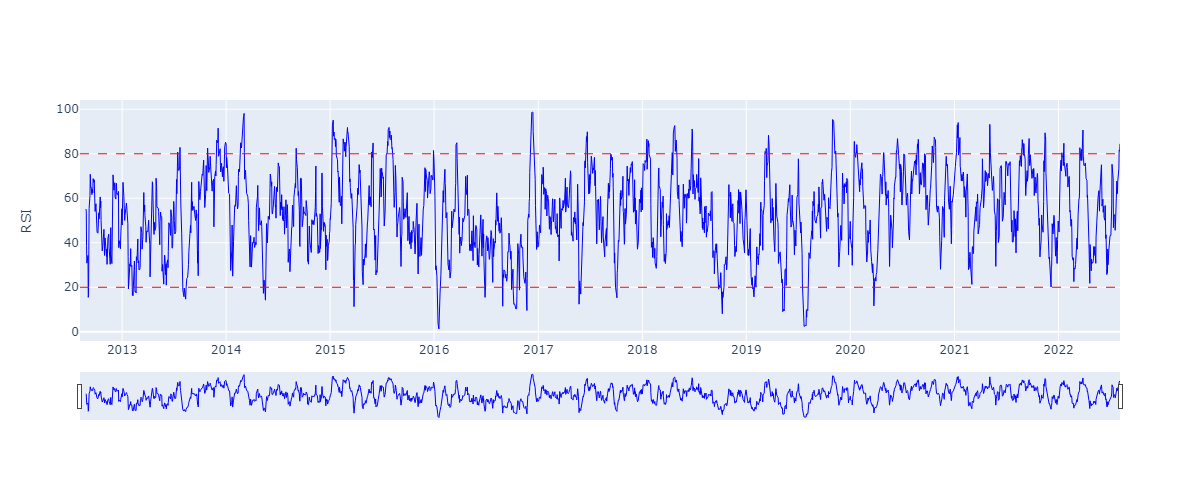

In [5]:
#RSI

def RSI(df,period):
    temp_df = pd.DataFrame()
    temp_df = df
    temp_df['Price_Change'] = temp_df['Close'] - temp_df['Close'].shift(1)
    temp_df['Daily_gain'] = np.where(temp_df['Price_Change']>=0,temp_df['Price_Change'],0)
    temp_df['Daily_loss'] = np.where(temp_df['Price_Change']<0,abs(temp_df['Price_Change']),0)
    temp_df['Avg_gain'] = temp_df['Daily_gain'].rolling(period).sum()
    temp_df['Avg_loss'] = temp_df['Daily_loss'].rolling(period).sum()
    temp_df['RS'] = temp_df['Avg_gain']/temp_df['Avg_loss']
    temp_df['RSI'] = (temp_df['RS']/(1+temp_df['RS']))*100
    df['RSI_'+str(period)] = temp_df['RSI']
        
RSI(stock_data,14)

candle = go.Candlestick(x=x_axis,
                       open=stock_data['Open'],
                       low=stock_data['Low'],
                       high=stock_data['High'],
                       close=stock_data['Close'])
    
RSI_data = stock_data['RSI_14']

RSI_curve = go.Scatter(x=x_axis, y=RSI_data, 
                      line=dict(color='blue', width=1), name="RSI")

fig = go.Figure()
fig.add_trace(RSI_curve)
#fig.add_trace(trace=candle)
                                              
fig.update_xaxes(
    rangeslider_visible=True)
fig.update_yaxes(title="RSI")

fig.update_layout(height=500, width=1200)

a = int(input("Enter overbought region\n") or 80)
b = int(input("Enter oversold region\n") or 20)

fig.add_hline(y=b, line_width=1, line_dash="dash", line_color="red")
fig.add_hline(y=a, line_width=1, line_dash="dash", line_color="red")

fig.show("png")

4.) Moving Average Convergence and Divergence (MACD)

Shorted Period

Longer Period

Signal Period



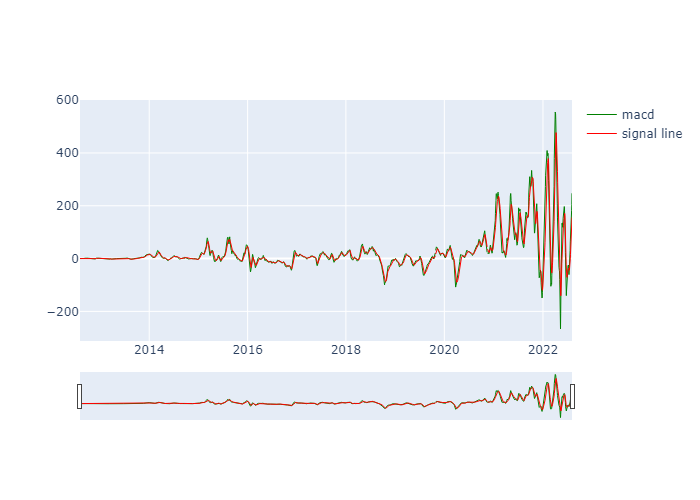

In [6]:
# MACD

sp = int(input("Shorted Period\n") or 12)
lp = int(input("Longer Period\n") or 26)
signal = int(input("Signal Period\n") or 9)

ema_sp = stock_data['Close'].ewm(span = sp, adjust=False).mean()
ema_lp = stock_data['Close'].ewm(span = lp, adjust=False).mean()

macd_data = ema_sp - ema_lp
#macd_data.drop(macd_data.index[0:lp], inplace=True)

stock_data['MACD'+str(sp)+'_'+str(lp)] = macd_data

signal_line_data = macd_data.ewm(span = signal, adjust=False).mean()

stock_data['MACD_Signal_'+str(signal)] = signal_line_data

macd = go.Scatter(x = x_axis, y = macd_data, line=dict(color='green', width=1), name="macd")
signal_line = go.Scatter(x = x_axis, y = signal_line_data, line=dict(color='red', width=1), name="signal line")

fig = go.Figure()

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                          #for holidays
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.add_trace(trace=macd)
fig.add_trace(trace=signal_line)
fig.update_xaxes(rangeslider_visible=True)
fig.show("png")

5.) Bollinger Bands (BB)

Enter the period for Bollinger Bands

How many times the standard deviation do you want to enclose the band within?


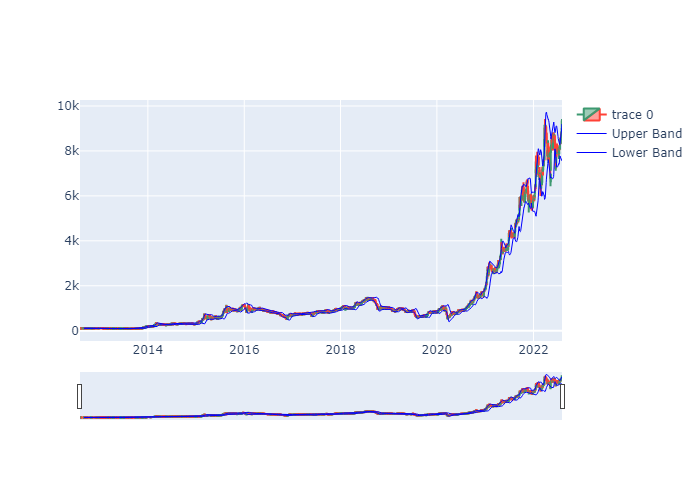

In [7]:
#Bollinger bands

x = int(input("Enter the period for Bollinger Bands\n") or 20)
y = float(input("How many times the standard deviation do you want to enclose the band within?") or 2)

SMA = stock_data['Close'].rolling(x).mean()
SD = stock_data['Close'].rolling(x).std(ddof=1)


plus_SD = SMA + (SD*y) 
minus_SD = SMA - (SD*y) 

candle = go.Candlestick(x=x_axis,
                       open=stock_data['Open'],
                       low=stock_data['Low'],
                       high=stock_data['High'],
                       close=stock_data['Close'])

Upper_band = go.Scatter(x=x_axis, y=plus_SD, line=dict(color='Blue', width=1), name="Upper Band")
Lower_band = go.Scatter(x=x_axis, y=minus_SD, line=dict(color='Blue', width=1), name="Lower Band")

fig =go.Figure()

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.add_trace(candle)
fig.add_trace(trace=Upper_band)
fig.add_trace(trace=Lower_band)
fig.show("png")

6.) ICHIMOKU

[*********************100%***********************]  1 of 1 completed


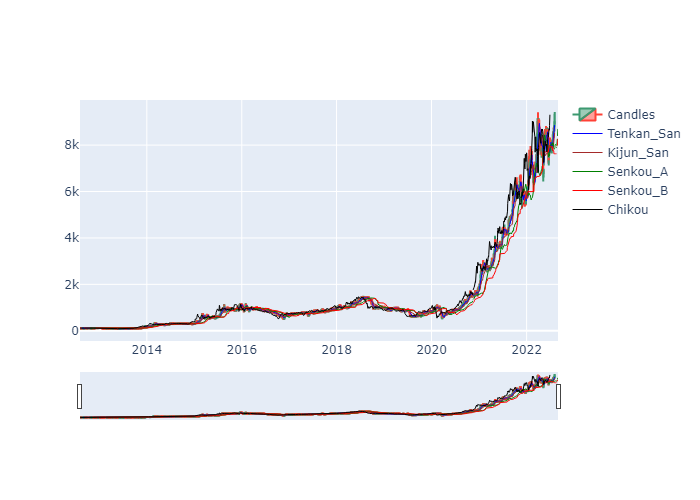

In [8]:
#for future days:

ichimoku_df = yf.download(tickers = stock_name + '.NS' ,period = '10y', interval = '1d')

temp_table = [np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]

date_series = pd.Series(stock_data.index)
sdate = date_series.iloc[date_series.shape[0]-1]
edate = sdate+timedelta(days=40)
delta = edate - sdate     
temp_list = []

for i in range(1,delta.days + 1):
    day = sdate + timedelta(days=i)
    temp_list.append(day)
    
temp_series= pd.Series(temp_list)
date_ser = date_series.append(temp_series, ignore_index=True)

for i in range(26):
    ichimoku_df.at[ichimoku_df.shape[0]] = temp_table

ichimoku_df = ichimoku_df.reset_index()


#Tenkan San

ichimoku_df['high_nine'] = ichimoku_df['High'].rolling(9).max()
ichimoku_df['low_nine'] = ichimoku_df['Low'].rolling(9).min()
ichimoku_df['Tenkan_San'] = (ichimoku_df['high_nine'] + ichimoku_df['low_nine'])/2

#Kijun San

ichimoku_df['high_twenty_six'] = ichimoku_df['High'].rolling(26).max()
ichimoku_df['low_twenty_six'] = ichimoku_df['Low'].rolling(26).min()
ichimoku_df['Kijun_San'] = (ichimoku_df['high_twenty_six'] + ichimoku_df['low_twenty_six'])/2

#Leading lines

ichimoku_df['Senkou_A'] = ((ichimoku_df['Tenkan_San'] + ichimoku_df['Kijun_San'])/2).shift(26)

ichimoku_df['high_fifty_two'] = ichimoku_df['High'].rolling(52).max()
ichimoku_df['low_fifty_two'] = ichimoku_df['Low'].rolling(52).min()

ichimoku_df['Senkou_B'] = ((ichimoku_df['high_fifty_two'] + ichimoku_df['low_fifty_two'])/2).shift(26)

#Lagging line

ichimoku_df['Chikou'] = ichimoku_df['Close'].shift(-26)


#Candlesticks

candle = go.Candlestick(x=date_ser,
                       open=ichimoku_df['Open'],
                       low=ichimoku_df['Low'],
                       high=ichimoku_df['High'],
                       close=ichimoku_df['Close'],
                       name='Candles')


fig = go.Figure()
                              
Conversion_Line = go.Scatter(x=date_ser, y=ichimoku_df['Tenkan_San'], line=dict(color='blue',width=1), name='Tenkan_San')
Base_Line = go.Scatter(x=date_ser, y=ichimoku_df['Kijun_San'], line=dict(color='Brown',width=1), name='Kijun_San')
Leading_A = go.Scatter(x=date_ser, y=ichimoku_df['Senkou_A'], line=dict(color='green',width=1), name='Senkou_A')
Leading_B = go.Scatter(x=date_ser, y=ichimoku_df['Senkou_B'], line=dict(color='red',width=1), name='Senkou_B')
Lagging = go.Scatter(x=date_ser, y=ichimoku_df['Chikou'], line=dict(color='Black',width=1), name='Chikou')


fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.add_trace(trace=candle)
fig.add_trace(trace=Conversion_Line)
fig.add_trace(trace=Base_Line)
fig.add_trace(trace=Leading_A)
fig.add_trace(trace=Leading_B)
fig.add_trace(trace=Lagging)

fig.show("png")

7.) Stochastic Oscillator

Enter the period for Stochastic Oscillator

Enter overbought region

Enter oversold region



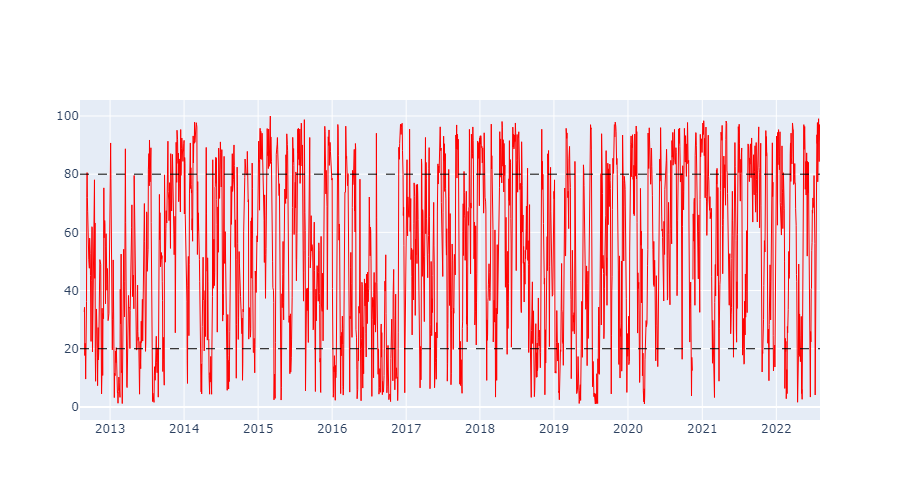

In [9]:
#Stochastic Oscillator

x = int(input('Enter the period for Stochastic Oscillator\n') or 14)
b = int(input('Enter overbought region\n') or 80)
a = int(input('Enter oversold region\n') or 20)

high_val = stock_data['High'].rolling(window=x).max()
low_val = stock_data['Low'].rolling(window=x).min()
curr_val = stock_data['Close']
so_num = curr_val - low_val
so_den = high_val- low_val
so = (so_num/so_den)*100

fig = go.Figure()

so_curve = go.Scatter(x=x_axis,y=so,
                     line=dict(color='red',width=1),
                     name='Stochastic_Curve')

fig.add_trace(trace=so_curve)
fig.add_hline(y=b, line_width=1, line_dash="dash", line_color="black")
fig.add_hline(y=a, line_width=1, line_dash="dash", line_color="black")

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=500, width=900)

fig.show("png")


8.) Average True Range (ATR)

Enter period for ATR


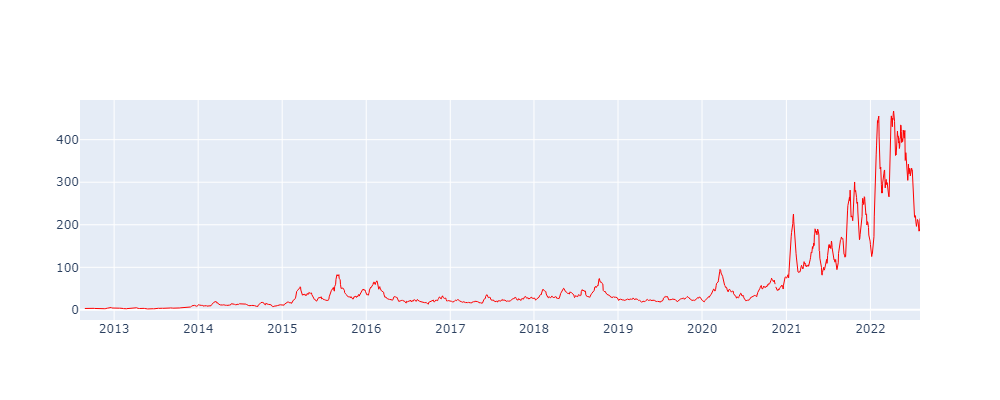

In [10]:
#ATR without library

x = int(input("Enter period for ATR") or 14)

curr_high = stock_data['High']
curr_low = stock_data['Low']
prev_close = stock_data['Close'].shift(1)

a = abs(curr_high-prev_close)
b = abs(curr_low-prev_close)
c = curr_high - curr_low
        
temp_df = pd.concat([a, b, c], axis=1)
temp_df['True_Range'] = temp_df.max(axis=1)
temp_df['ATR'] = temp_df['True_Range'].rolling(x).mean()

#adding data to our df
stock_data['True_Range'] = temp_df['True_Range']
stock_data['ATR'] = temp_df['ATR']

fig = go.Figure()

ATR_curve = go.Scatter(x=x_axis, y=temp_df['ATR'],
                      line=dict(color='red',width=1),
                      name='ATR')

fig.add_trace(trace=ATR_curve)

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=400, width=1000)
fig.show("png")

9.) Average Directional Index (ADX)

[*********************100%***********************]  1 of 1 completed


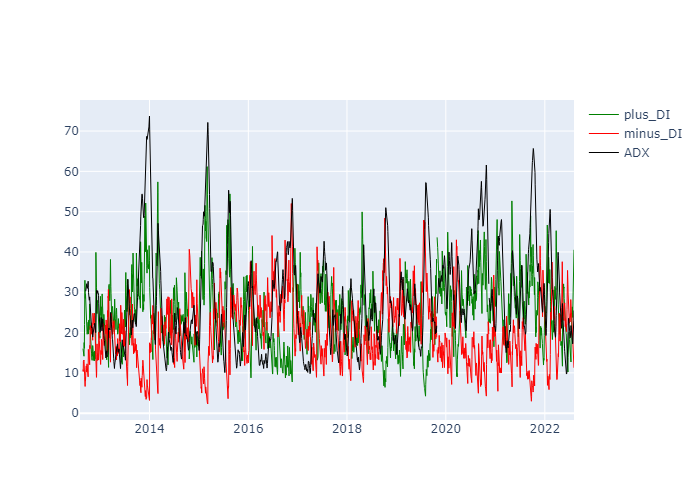

In [11]:
#ADX

temp_df = yf.download(tickers = stock_name + '.NS' ,period = '10y', interval = '1d')
temp_df['True_Range'] = stock_data['True_Range']
x_axis = temp_df.index

temp_df['plus_DM'] = np.where(((temp_df['High'] - temp_df['High'].shift(1)) >
                                 (temp_df['Low'].shift(1) - temp_df['Low'])) &
                                ((temp_df['High'] - temp_df['High'].shift(1)) > 0),
                                (temp_df['High'] - temp_df['High'].shift(1)),0)

temp_df['minus_DM'] = np.where(((temp_df['High'] - temp_df['High'].shift(1)) <
                                 (temp_df['Low'].shift(1) - temp_df['Low'])) &
                                ((temp_df['Low'].shift(1) - temp_df['Low']) > 0),
                                (temp_df['Low'].shift(1) - temp_df['Low']),0)


def wilder_smoothening(name):
    smooth_it = 'smooth_'+name
    first_smooth = temp_df[name].head(14).sum()

    temp_df[smooth_it] = np.nan

    temp_df.at[temp_df.index[14],smooth_it] = first_smooth

    temp = first_smooth

    for i in range(15,temp_df.shape[0]):
        temp_df.at[temp_df.index[i],smooth_it] = temp - temp/14 + temp_df.loc[temp_df.index[i],name]
        temp = temp_df.loc[temp_df.index[i],smooth_it]

wilder_smoothening('True_Range')
wilder_smoothening('plus_DM')
wilder_smoothening('minus_DM')


temp_df['plus_DI'] = (temp_df['smooth_plus_DM']/temp_df['smooth_True_Range'])*100
temp_df['minus_DI'] = (temp_df['smooth_minus_DM']/temp_df['smooth_True_Range'])*100

temp_df['DX'] = ((abs(temp_df['plus_DI'] - temp_df['minus_DI']))/
                   (temp_df['plus_DI'] + temp_df['minus_DI'])) * 100

temp_sum = 0
for i in range(15,28):
    temp_sum += temp_df.loc[temp_df.index[i],'DX']

first_ADX = temp_sum/14

temp_df['ADX'] = np.nan

temp_df.at[temp_df.index[28],'ADX'] = first_ADX

temp = first_ADX

for i in range(29,temp_df.shape[0]):
    temp_df.at[temp_df.index[i],'ADX'] = ((temp*13) + temp_df.loc[temp_df.index[i],'DX'])/14
    temp = temp_df.loc[temp_df.index[i],'ADX']
    
#adding data to our df
stock_data['plus_DI'] = temp_df['plus_DI']
stock_data['minus_DI'] = temp_df['minus_DI']
stock_data['ADX'] = temp_df['ADX']
    
fig = go.Figure()
                              

plus_DI = go.Scatter(x=x_axis, y=temp_df['plus_DI'], line=dict(color='green',width=1), name='plus_DI')
minus_DI = go.Scatter(x=x_axis, y=temp_df['minus_DI'], line=dict(color='red',width=1), name='minus_DI')
ADX = go.Scatter(x=x_axis, y=temp_df['ADX'], line=dict(color='Black',width=1), name='ADX')


fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.add_trace(trace=plus_DI)
fig.add_trace(trace=minus_DI)
fig.add_trace(trace=ADX)

fig.show("png")


10.) Commodity Channel Indicator (CCI)

Enter the period



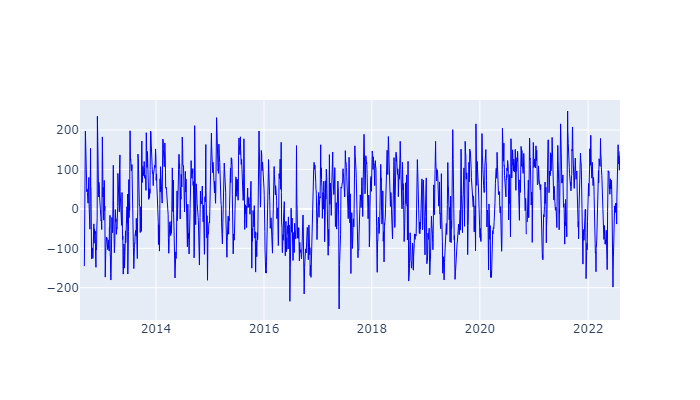

In [12]:
#CCI

x = int(input("Enter the period\n") or 20)

Typical_Price = (stock_data['High'] + 
                 stock_data['Low'] + 
                 stock_data['Close'])/3

TP_sma = Typical_Price.rolling(x).mean()
TP_std = Typical_Price.rolling(x).std()

CCI = (((Typical_Price) - (TP_sma))/(0.015*TP_std))

fig = go.Figure()

CCI_curve = go.Scatter(x=x_axis, y=CCI,
                      line=dict(color='blue',width=1),
                      name='CCI')

fig.add_trace(trace=CCI_curve)

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.update_layout(height=400, width=700)
fig.show("png")

11.) Parabolic Support and Resistance (PSAR)

[*********************100%***********************]  1 of 1 completed


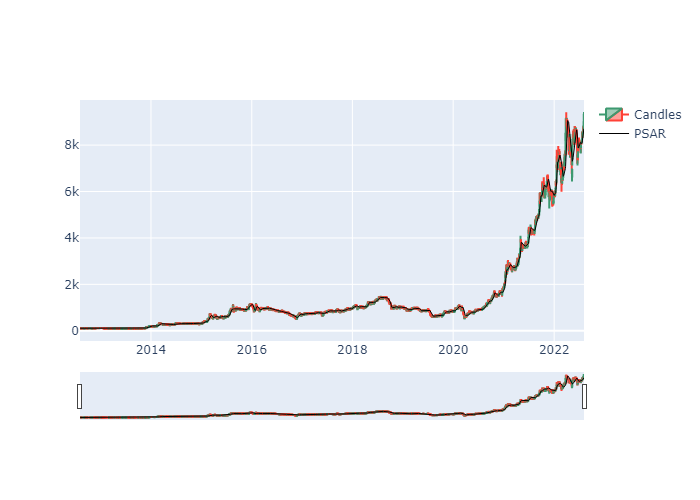

In [13]:
#plotting Parabolic SAR

temp_df = yf.download(tickers = stock_name + '.NS' ,period = '10y', interval = '1d')
x_axis = temp_df.index

first_PSAR = temp_df.loc[temp_df.index[0],'Low']
first_EP = temp_df.loc[temp_df.index[0],'High']

temp_df[['PSAR','EP','EP_PSAR','Acc_EP_PSAR','Acc','Trend']] = np.nan

temp_df.at[temp_df.index[0],'PSAR'] = first_PSAR
temp_df.at[temp_df.index[0],'EP'] = first_EP
temp_df.at[temp_df.index[0],'Trend'] = 1
temp_df.at[temp_df.index[0],'Acc'] = 0.02
temp_df.at[temp_df.index[0],'EP_PSAR'] = first_EP - first_PSAR
temp_df.at[temp_df.index[0],'Acc_EP_PSAR'] = (first_EP - first_PSAR)*0.02

def psar(i):
    #PSAR
    temp_df.at[temp_df.index[i],'PSAR'] = temp_df.loc[temp_df.index[i-1],'PSAR'] + temp_df.loc[temp_df.index[i-1],'Acc_EP_PSAR']
    
    #Trend
    
    if(temp_df.loc[temp_df.index[i],'PSAR'] < temp_df.loc[temp_df.index[i],'High']):
        temp_df.at[temp_df.index[i],'Trend'] = 1
    elif(temp_df.loc[temp_df.index[i],'PSAR'] > temp_df.loc[temp_df.index[i],'Low']):
        temp_df.at[temp_df.index[i],'Trend'] = -1
    
    #EP
    
    if(temp_df.loc[temp_df.index[i],'Trend'] == 1):
        if(temp_df.loc[temp_df.index[i],'High']>temp_df.loc[temp_df.index[i-1],'EP']):
            temp_df.at[temp_df.index[i],'EP'] = temp_df.loc[temp_df.index[i],'High']
        else:
            temp_df.at[temp_df.index[i],'EP'] = temp_df.loc[temp_df.index[i-1],'EP']
    elif(temp_df.loc[temp_df.index[i],'Trend'] == -1):
        if(temp_df.loc[temp_df.index[i],'Low']<temp_df.loc[temp_df.index[i-1],'EP']):
            temp_df.at[temp_df.index[i],'EP'] = temp_df.loc[temp_df.index[i],'Low']
        else:
            temp_df.at[temp_df.index[i],'EP'] = temp_df.loc[temp_df.index[i-1],'EP']
    
    #EP_PSAR
    
    temp_df.at[temp_df.index[i],'EP_PSAR'] = temp_df.at[temp_df.index[i],'EP'] - temp_df.at[temp_df.index[i],'PSAR']
    
    #Acc
  
    if(temp_df.loc[temp_df.index[i],'Trend'] == temp_df.loc[temp_df.index[i-1],'Trend']):
        if(temp_df.loc[temp_df.index[i],'Trend'] == 1):
            if(temp_df.loc[temp_df.index[i],'EP'] > temp_df.loc[temp_df.index[i-1],'EP']):
                if(temp_df.loc[temp_df.index[i-1],'Acc']>0.2):
                    temp_df.at[temp_df.index[i],'Acc'] = 0.2
                else:
                    temp_df.at[temp_df.index[i],'Acc'] = temp_df.loc[temp_df.index[i-1],'Acc'] + 0.02
            else:
                temp_df.at[temp_df.index[i],'Acc'] = temp_df.loc[temp_df.index[i-1],'Acc']

        if(temp_df.loc[temp_df.index[i],'Trend'] == -1):
            if(temp_df.loc[temp_df.index[i],'EP'] < temp_df.loc[temp_df.index[i-1],'EP']):
                if(temp_df.loc[temp_df.index[i-1],'Acc'] < 0.2):
                    temp_df.at[temp_df.index[i],'Acc'] = temp_df.loc[temp_df.index[i-1],'Acc'] + 0.02
                else:
                    temp_df.at[temp_df.index[i],'Acc'] = 0.2
            else:
                temp_df.at[temp_df.index[i],'Acc'] = temp_df.loc[temp_df.index[i-1],'Acc']
    else:
        temp_df.at[temp_df.index[i],'Acc'] = 0.02
    
    #Acc_EP_PSAR
    
    temp_df.at[temp_df.index[i],'Acc_EP_PSAR'] = temp_df.at[temp_df.index[i],'EP_PSAR'] * temp_df.at[temp_df.index[i],'Acc']
    
for x in range(1, temp_df.shape[0]):
    psar(x)

#adding data to our df
stock_data['PSAR'] = temp_df['PSAR']
stock_data['Trend'] = temp_df['Trend']
    
candle = go.Candlestick(x=x_axis,
                       open=temp_df['Open'],
                       low=temp_df['Low'],
                       high=temp_df['High'],
                       close=temp_df['Close'],
                       name='Candles')

PSAR_data = go.Scatter(x=x_axis, y=temp_df['PSAR'], line=dict(color='black',width=1), name='PSAR')

fig = go.Figure()

fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]), 
        dict(values=[])                      
        #dict(bounds=[15.5, 9.25], pattern="hour")
    ]
)

fig.add_trace(trace=candle)
fig.add_trace(trace=PSAR_data)

fig.show("png")

In [14]:
stock_data_indicator_df = stock_data.copy()